# ***California Housing Price Prediction - SGD Regression***
***Nov 2025***

# 🔶Import Libraries

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import skew, boxcox, yeojohnson

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import missingno as msno

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.impute import SimpleImputer # For Missing Value Handeling
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline, clone
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score

import time
import joblib

# 🔶Data Overview

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## ⮞Casting Object Data as Categorical Data

In [3]:
df['ocean_proximity'] = df['ocean_proximity'].astype('category')
df.dtypes

,0
longitude,float64
latitude,float64
housing_median_age,float64
total_rooms,float64
total_bedrooms,float64
population,float64
households,float64
median_income,float64
median_house_value,float64
ocean_proximity,category


# 🔶Train-Test Split

In [4]:
# Create income categories
df["income_cat"] = pd.cut(
    df["median_income"],
    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
    labels=[1, 2, 3, 4, 5]
)

In [5]:
# Test Size = 20%
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in split.split(df, df["income_cat"]):
    train_set = df.loc[train_idx]
    test_set = df.loc[test_idx]

# Drop income-cat, it was only used for splitting
for set_ in (train_set, test_set):
    set_.drop("income_cat", axis=1, inplace=True)

print(f'Shape of Train Set: {train_set.shape}')
print(f'Shape of Test Set: {test_set.shape}')

Shape of Train Set: (16512, 10)
Shape of Test Set: (4128, 10)


# 🔶Missing Values

## ⮞Handeling Missing Values

In [6]:
print(f' mean={train_set['total_bedrooms'].mean()}\n median={train_set['total_bedrooms'].median()}\n mode={train_set['total_bedrooms'].mode()}')

 mean=538.9490944689182
 median=434.0
 mode=0    345.0
Name: total_bedrooms, dtype: float64


In [7]:
# Replacing the missing values in the train_set with the median of the column:
train_median = train_set['total_bedrooms'].median()

train_set.fillna({'total_bedrooms' : train_median}, inplace=True)
train_set['total_bedrooms'].isna().sum()

np.int64(0)

In [8]:
# Alternative method for missing value handeling using sklearn imputer
"""
imputer = SimpleImputer(strategy='median')

cols = train_set.select_dtypes('float64').columns   # Imputer won't work with non-numeric columns
imputer.fit_transform(train_set[cols])
imputer.statistics_, m

imputer.transform(test_set)
"""

"\nimputer = SimpleImputer(strategy='median')\n\ncols = train_set.select_dtypes('float64').columns   # Imputer won't work with non-numeric columns\nimputer.fit_transform(train_set[cols])\nimputer.statistics_, m\n\nimputer.transform(test_set)\n"

# 🔶Encoding Categorical Features

In [9]:
train_set.ocean_proximity.unique()

['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND']
Categories (5, object): ['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']

## ⮞One-Hot Encoding

In [10]:
train_set = pd.get_dummies(train_set, columns=['ocean_proximity'], dtype=np.float64)

## ⮞Creating More Codeable Column Name in the Train Set

In [11]:
# Lower case, No space
train_set.rename(columns={'ocean_proximity_<1H OCEAN' : 'ocean_proximity_1h_ocean',
                          'ocean_proximity_INLAND' :'ocean_proximity_inland',
                          'ocean_proximity_ISLAND' : 'ocean_proximity_island',
                          'ocean_proximity_NEAR BAY' : 'ocean_proximity_near_bay',
                          'ocean_proximity_NEAR OCEAN' : 'ocean_proximity_near_ocean'},
                 inplace=True)
train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_1h_ocean,ocean_proximity_inland,ocean_proximity_island,ocean_proximity_near_bay,ocean_proximity_near_ocean
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,0.0,0.0,0.0,1.0,0.0
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,1.0,0.0,0.0,0.0,0.0
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,0.0,1.0,0.0,0.0,0.0
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,0.0,1.0,0.0,0.0,0.0
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,0.0,0.0,0.0,0.0,1.0


# 🔶Outliers

## ⮞Univariate Analysis

### ▸Numerical Features

In [12]:
# Make a copy of the dataset to apply feature transformation
preprocessed_train_set = train_set.copy()

In [13]:
# Apply feature transformation
cols_to_transform = ['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
lambda_list = []
for col in cols_to_transform:
  preprocessed_train_set[col], lm = yeojohnson(train_set[col])
  lambda_list.append(lm)      # This will be used for test_set feature transformation

In [14]:
desc = preprocessed_train_set[cols_to_transform].describe()
Q1 = desc.loc['25%']
Q3 = desc.loc['75%']
IQR = Q3 - Q1
#lower_cap = Q1 - 1.5 * IQR   # we increase the range between two caps to 3.3IQR so that a smaller number of samples will be considered as outliers.
#upper_cap = Q3 + 1.5 * IQR
lower_cap = Q1 - 3.3 * IQR
upper_cap = Q3 + 3.3 * IQR

flags = (preprocessed_train_set[cols_to_transform] < lower_cap) | (preprocessed_train_set[cols_to_transform] > upper_cap)
flags.sum()

,0
total_rooms,25
total_bedrooms,23
population,12
households,19
median_income,0
median_house_value,0


In [15]:
# Summing up the outliers in rows to detect the actual number of outlier sampels withot overlappng
print(f' Total number of outlier samples: {flags.sum(1).astype(np.bool_).sum()}')

 Total number of outlier samples: 36


In [16]:
# dropping the outliers(outside the range of caps)

print(f'Number of samples before dropping the outliers:{preprocessed_train_set.shape[0]}')
print(f'Number of outliers to drop:{flags.sum(1).astype(np.bool_).sum()}')

# drop
preprocessed_train_set = preprocessed_train_set[~flags.sum(1).astype(np.bool_)]

print(f'Number of samples after dropping the outliers:{preprocessed_train_set.shape[0]}')

Number of samples before dropping the outliers:16512
Number of outliers to drop:36
Number of samples after dropping the outliers:16476


Number of outliers in median_house_value: 807


Text(0.5, 1.0, 'Median House Value Without the Outlier Bar at $500000(32.5 after transformation)')

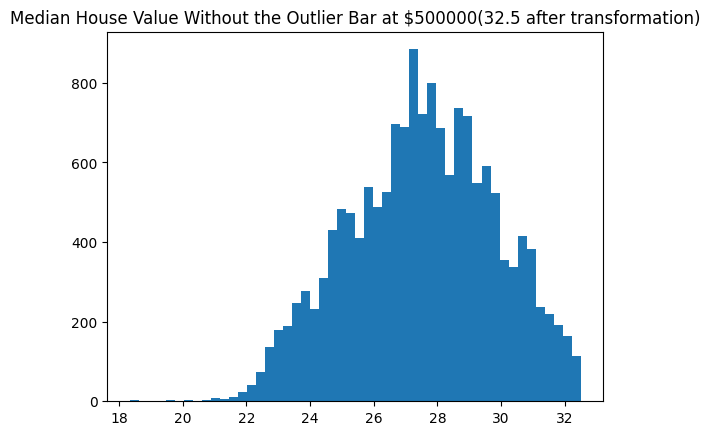

In [17]:
# Handling the outliers in median_house_value(~800 samples at $500,000)
flags = preprocessed_train_set.median_house_value < 32.5
print(f'Number of outliers in median_house_value: {(~flags).sum()}')
plt.hist(preprocessed_train_set.median_house_value[flags], 50);
plt.title('Median House Value Without the Outlier Bar at $500000(32.5 after transformation)')

In [18]:
# dropping the outliers(capped at $500,000)

print(f'Number of samples before dropping the outliers:{preprocessed_train_set.shape[0]}')
print(f'Number of outliers to drop:{(~flags).sum()}')

# drop
preprocessed_train_set = preprocessed_train_set[flags]

print(f'Number of samples after dropping the outliers:{preprocessed_train_set.shape[0]}')

Number of samples before dropping the outliers:16476
Number of outliers to drop:807
Number of samples after dropping the outliers:15669


In [19]:
# Apply exponent feature transform on median house value to fix the left skew

preprocessed_train_set['median_house_value'] = (preprocessed_train_set.median_house_value)**1.8

In [20]:
# dropping the outliers(Lower than 240)
flags = preprocessed_train_set['median_house_value'] < 240
print(f'Number of samples before dropping the outliers:{preprocessed_train_set.shape[0]}')
print(f'Number of outliers to drop:{flags.sum()}')

# drop
preprocessed_train_set = preprocessed_train_set[~flags]

print(f'Number of samples after dropping the outliers:{preprocessed_train_set.shape[0]}')

Number of samples before dropping the outliers:15669
Number of outliers to drop:18
Number of samples after dropping the outliers:15651


### ▸Categorical Features

In [21]:
preprocessed_train_set.iloc[:, 9:].sum()

,0
ocean_proximity_1h_ocean,6814.0
ocean_proximity_inland,5252.0
ocean_proximity_island,2.0
ocean_proximity_near_bay,1679.0
ocean_proximity_near_ocean,1904.0


In [22]:
# Dropping the ocean_proximity_island due to the mentioned reasons
preprocessed_train_set.drop(columns='ocean_proximity_island', inplace=True)
preprocessed_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_1h_ocean,ocean_proximity_inland,ocean_proximity_near_bay,ocean_proximity_near_ocean
13096,-122.42,37.80,52.0,21.885560,16.237258,19.989298,17.559147,1.015860,515.734944,0.0,0.0,1.0,0.0
14973,-118.38,34.14,40.0,19.059757,11.705350,15.516368,12.730667,1.630253,523.506281,1.0,0.0,0.0,0.0
3785,-121.98,38.36,33.0,16.215315,10.087305,14.737976,10.622497,1.097377,336.524088,0.0,1.0,0.0,0.0
14689,-117.11,33.75,17.0,23.219759,15.067641,20.911629,16.158466,1.056877,331.008794,0.0,1.0,0.0,0.0
20507,-118.15,33.77,36.0,23.490025,16.608470,21.125243,18.212246,1.309943,482.986761,0.0,0.0,0.0,1.0


## ⮞Bivariate Analysis

In [23]:
# Make a copy of the dataset to later examine the model's performance with and without the outliers
clean_train_set = preprocessed_train_set.copy()

Text(0.5, 1.0, 'Number of Outliers in Median House Value Vs. Longitude: 24')

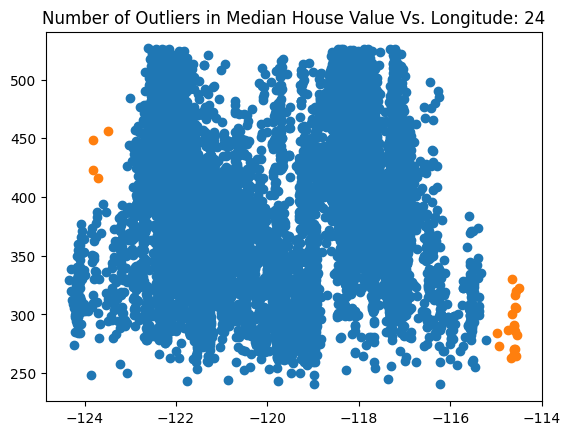

In [24]:
# Outliers in longitude
flag1 = (clean_train_set.longitude < -123.2) & (clean_train_set.median_house_value > 410)
flag2 = clean_train_set.longitude > -115
flags = flag1 | flag2
count = flags.sum()

plt.scatter(clean_train_set.longitude[~flags], clean_train_set.median_house_value[~flags])
plt.scatter(clean_train_set.longitude[flags], clean_train_set.median_house_value[flags])
plt.title(f'Number of Outliers in Median House Value Vs. Longitude: {count}')

In [25]:
# dropping the flagged outliers

print(f'Number of samples before dropping the outliers:{clean_train_set.shape[0]}')
print(f'Number of outliers to drop:{count}')

# drop
clean_train_set = clean_train_set[~flags]

print(f'Number of samples after dropping the outliers:{clean_train_set.shape[0]}')

Number of samples before dropping the outliers:15651
Number of outliers to drop:24
Number of samples after dropping the outliers:15627


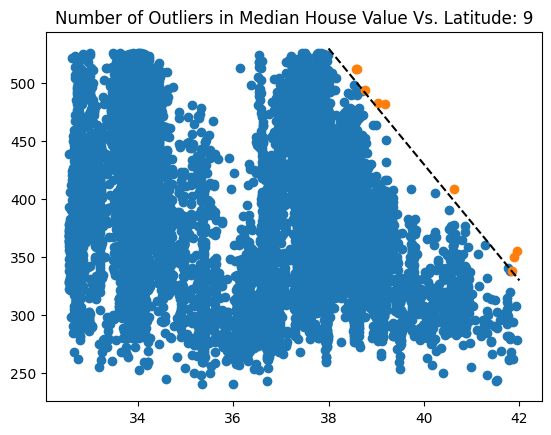

In [26]:
# Outliers in latitude
m = -50
b = 2430
flag1 = clean_train_set.median_house_value > (m * clean_train_set.latitude + b)
flags =  flag1
count = flags.sum()

plt.scatter(clean_train_set.latitude[~flags], clean_train_set.median_house_value[~flags])
plt.scatter(clean_train_set.latitude[flags], clean_train_set.median_house_value[flags])
plt.title(f'Number of Outliers in Median House Value Vs. Latitude: {count}')

# Plot the line
lat_range = np.linspace(38,42, 20)
plt.plot(lat_range, m * lat_range + b, 'k--')

In [27]:
# dropping the flagged outliers

print(f'Number of samples before dropping the outliers:{clean_train_set.shape[0]}')
print(f'Number of outliers to drop:{count}')

# drop
clean_train_set = clean_train_set[~flags]

print(f'Number of samples after dropping the outliers:{clean_train_set.shape[0]}')

Number of samples before dropping the outliers:15627
Number of outliers to drop:9
Number of samples after dropping the outliers:15618


Text(0.5, 1.0, 'Number of Outliers in Median House Value Vs. Housing_median_age: 869')

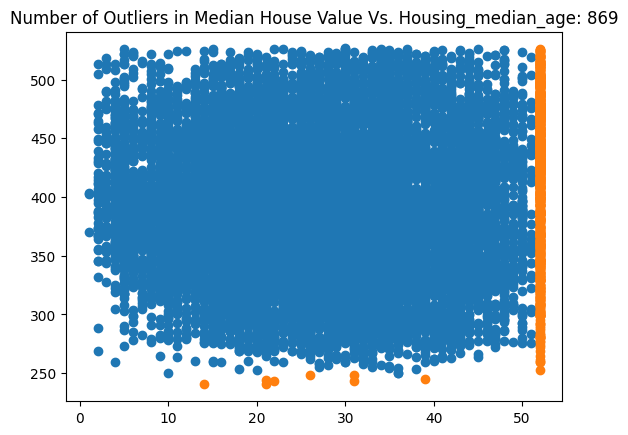

In [28]:
# Outliers in housing_median_age
flag1 = clean_train_set.median_house_value < 250
flag2 = clean_train_set.housing_median_age > 51
flags = flag1 | flag2
count = flags.sum()

plt.scatter(clean_train_set.housing_median_age[~flags], clean_train_set.median_house_value[~flags])
plt.scatter(clean_train_set.housing_median_age[flags], clean_train_set.median_house_value[flags])
plt.title(f'Number of Outliers in Median House Value Vs. Housing_median_age: {count}')

In [29]:
# dropping the flagged outliers

print(f'Number of samples before dropping the outliers:{clean_train_set.shape[0]}')
print(f'Number of outliers to drop:{count}')

# drop
clean_train_set = clean_train_set[~flags]

print(f'Number of samples after dropping the outliers:{clean_train_set.shape[0]}')

Number of samples before dropping the outliers:15618
Number of outliers to drop:869
Number of samples after dropping the outliers:14749


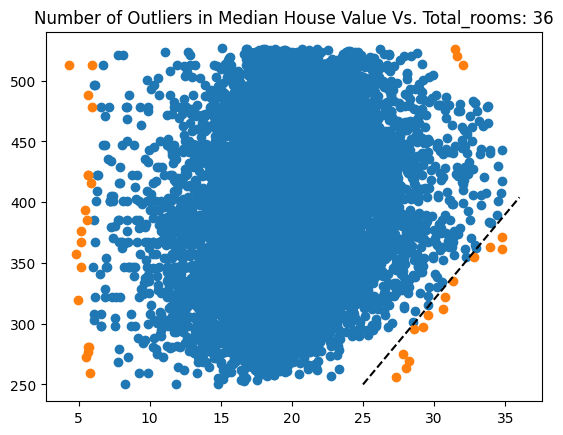

In [30]:
# Outliers in total_rooms
m = 14
b = -100
flag1 = clean_train_set.median_house_value < (m * clean_train_set.total_rooms + b)
flag2 = (clean_train_set.total_rooms > 31) & (clean_train_set.median_house_value > 510)
flag3 = clean_train_set.total_rooms < 6
flags =  flag1 | flag2 | flag3
count = flags.sum()

plt.scatter(clean_train_set.total_rooms[~flags], clean_train_set.median_house_value[~flags])
plt.scatter(clean_train_set.total_rooms[flags], clean_train_set.median_house_value[flags])
plt.title(f'Number of Outliers in Median House Value Vs. Total_rooms: {count}')

# Plot the line
l_range = np.linspace(25,36, 20)
plt.plot(l_range, m * l_range + b, 'k--')

In [31]:
# dropping the flagged outliers

print(f'Number of samples before dropping the outliers:{clean_train_set.shape[0]}')
print(f'Number of outliers to drop:{count}')

# drop
clean_train_set = clean_train_set[~flags]

print(f'Number of samples after dropping the outliers:{clean_train_set.shape[0]}')

Number of samples before dropping the outliers:14749
Number of outliers to drop:36
Number of samples after dropping the outliers:14713


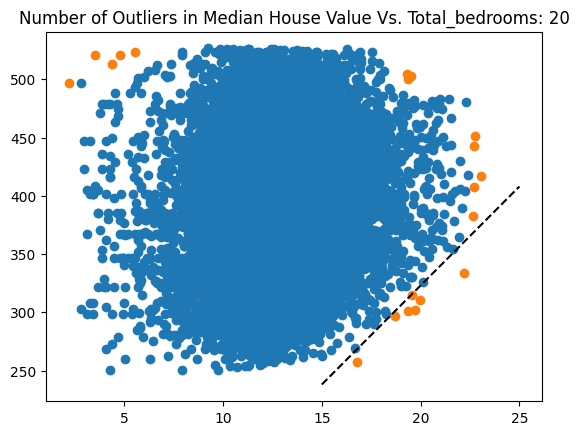

In [32]:
# Outliers in total_bedrooms
m = 17
b = -17
flag1 = clean_train_set.median_house_value < (m * clean_train_set.total_bedrooms + b)
flag2 = (clean_train_set.total_bedrooms > 18.5) & (clean_train_set.median_house_value > 500)
flag3 = (clean_train_set.total_bedrooms < 6) & (clean_train_set.median_house_value > 501)
flag4 = (clean_train_set.total_bedrooms > 22.5) | (clean_train_set.total_bedrooms < 2.5)
flags =  flag1 | flag2 | flag3 | flag4
count = flags.sum()

plt.scatter(clean_train_set.total_bedrooms[~flags], clean_train_set.median_house_value[~flags])
plt.scatter(clean_train_set.total_bedrooms[flags], clean_train_set.median_house_value[flags])
plt.title(f'Number of Outliers in Median House Value Vs. Total_bedrooms: {count}')

# Plot the line
l_range = np.linspace(15,25, 20)
plt.plot(l_range, m * l_range + b, 'k--')

In [33]:
# dropping the flagged outliers

print(f'Number of samples before dropping the outliers:{clean_train_set.shape[0]}')
print(f'Number of outliers to drop:{count}')

# drop
clean_train_set = clean_train_set[~flags]

print(f'Number of samples after dropping the outliers:{clean_train_set.shape[0]}')

Number of samples before dropping the outliers:14713
Number of outliers to drop:20
Number of samples after dropping the outliers:14693


Text(0.5, 1.0, 'Number of Outliers in Median House Value Vs. Population: 5')

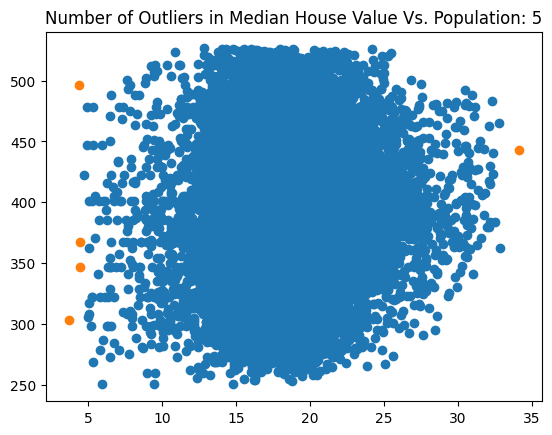

In [34]:
# Outliers in population
flag1 = clean_train_set.median_house_value < 250
flag2 = (clean_train_set.population < 4.5) | (clean_train_set.population > 33)
flags = flag1 | flag2
count = flags.sum()

plt.scatter(clean_train_set.population[~flags], clean_train_set.median_house_value[~flags])
plt.scatter(clean_train_set.population[flags], clean_train_set.median_house_value[flags])
plt.title(f'Number of Outliers in Median House Value Vs. Population: {count}')

In [35]:
# dropping the flagged outliers

print(f'Number of samples before dropping the outliers:{clean_train_set.shape[0]}')
print(f'Number of outliers to drop:{count}')

# drop
clean_train_set = clean_train_set[~flags]

print(f'Number of samples after dropping the outliers:{clean_train_set.shape[0]}')

Number of samples before dropping the outliers:14693
Number of outliers to drop:5
Number of samples after dropping the outliers:14688


Text(0.5, 1.0, 'Number of Outliers in Median House Value Vs. Households: 24')

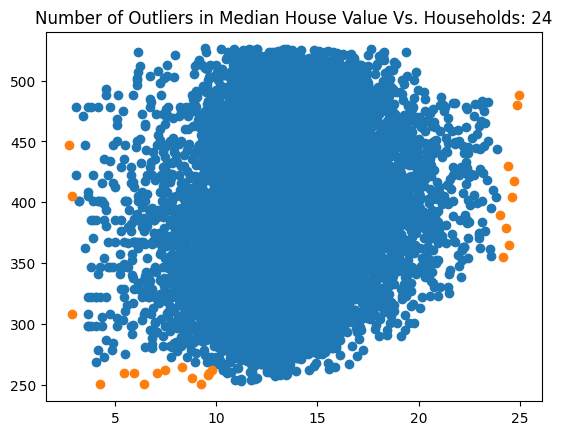

In [36]:
# Outliers in households
flag1 = (clean_train_set.households > 20) & (clean_train_set.median_house_value > 500)
flag2 = (clean_train_set.households < 3) | (clean_train_set.households > 24)
flag3 = (clean_train_set.households < 10) & (clean_train_set.median_house_value < 265)
flags = flag1 | flag2 | flag3
count = flags.sum()

plt.scatter(clean_train_set.households[~flags], clean_train_set.median_house_value[~flags])
plt.scatter(clean_train_set.households[flags], clean_train_set.median_house_value[flags])
plt.title(f'Number of Outliers in Median House Value Vs. Households: {count}')

In [37]:
# dropping the flagged outliers

print(f'Number of samples before dropping the outliers:{clean_train_set.shape[0]}')
print(f'Number of outliers to drop:{count}')

# drop
clean_train_set = clean_train_set[~flags]

print(f'Number of samples after dropping the outliers:{clean_train_set.shape[0]}')

Number of samples before dropping the outliers:14688
Number of outliers to drop:24
Number of samples after dropping the outliers:14664


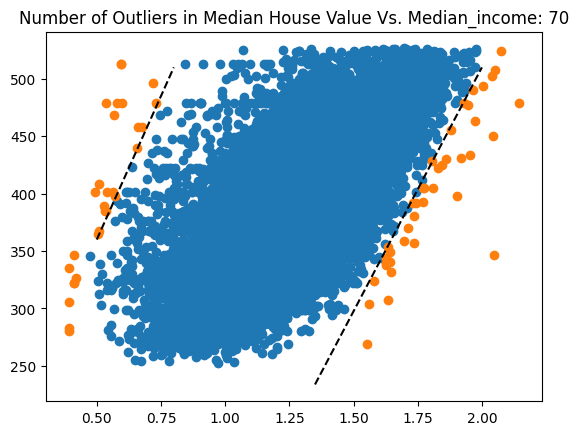

In [38]:
# Outliers in median_income
m1 = 425
b1 = -340
m2 = 500
b2 = 110
flag1 = clean_train_set.median_house_value < (m1 * clean_train_set.median_income + b1)
flag2 = clean_train_set.median_house_value > (m2 * clean_train_set.median_income + b2)
flag3 = (clean_train_set.median_income < 0.45)
flags = flag1 | flag2 | flag3
count = flags.sum()

plt.scatter(clean_train_set.median_income[~flags], clean_train_set.median_house_value[~flags])
plt.scatter(clean_train_set.median_income[flags], clean_train_set.median_house_value[flags])
plt.title(f'Number of Outliers in Median House Value Vs. Median_income: {count}')
# Plot the lines
l1_range = np.linspace(1.35,2, 20)
plt.plot(l1_range, m1 * l1_range + b1, 'k--')
l2_range = np.linspace(0.5,0.8, 20)
plt.plot(l2_range, m2 * l2_range + b2, 'k--')

In [39]:
# dropping the flagged outliers

print(f'Number of samples before dropping the outliers:{clean_train_set.shape[0]}')
print(f'Number of outliers to drop:{count}')

# drop
clean_train_set = clean_train_set[~flags]

print(f'Number of samples after dropping the outliers:{clean_train_set.shape[0]}')

Number of samples before dropping the outliers:14664
Number of outliers to drop:70
Number of samples after dropping the outliers:14594


Now that we have identified the outliers through bivariate analysis, we can evaluate their impact on the model. The approach is to first use the dataset that retains all outliers(preprocessed_train_set), build and train the model, and record its performance. Then, we can use the dataset in which the detected outliers are removed(clean_train_set), retrain the model, and compare the results.

By examining the performance difference between the two scenarios, we can make an informed decision about whether keeping or removing the outliers leads to a more robust and reliable model.

# 🔶Data/Feature Reduction

In [40]:
corr = preprocessed_train_set.corr()
corr[['median_house_value']].abs().sort_values(by='median_house_value')

,median_house_value
longitude,0.028536
housing_median_age,0.046773
population,0.051845
total_bedrooms,0.109908
ocean_proximity_near_ocean,0.131981
households,0.138668
ocean_proximity_near_bay,0.164057
latitude,0.182600
total_rooms,0.197033
ocean_proximity_1h_ocean,0.337791


**Interpretation on Feature Selection**

At this stage, we examine the strength of the relationship between each feature and the target variable to guide feature selection. Columns with very low correlation or weak relevance to the prediction task—such as housing median age or population—could potentially be removed depending on the project needs.

Also, for simplicity, PCA (Principal Component Analysis) or other dimensionality reduction techniques were not applied.

For now, we will keep all features to avoid prematurely discarding information that may still contribute to model performance. Later, once we build and evaluate our models, we can revisit feature selection and decide whether removing certain features improves model accuracy, simplifies the model, or speeds up computation.

# 🔶X & Y Split

In [41]:
# Separate the dataset into features (X) and the target variable (y)- Outliers retained
x_train = preprocessed_train_set.drop(columns=['median_house_value'])
y_train = preprocessed_train_set['median_house_value']

x_train.shape, y_train.shape

((15651, 12), (15651,))

In [42]:
# Separate the dataset into features (X) and the target variable (y)- Outliers removed
x_train_c = clean_train_set.drop(columns=['median_house_value'])
y_train_c = clean_train_set['median_house_value']

x_train_c.shape, y_train_c.shape

((14594, 12), (14594,))

# 🔶Model Selection

**Model Selection:**

For this Project, I selected the Stochastic Gradient Descent Regressor (SGDRegressor) with Elastic Net regularization, which combines both L1 and L2 penalties. Elastic Net is particularly useful for:
* Reducing overfitting on high-dimensional datasets.
* Automatically performing feature selection via L1 regularization (lasso effect).
* Providing numerical stability with correlated features via L2 regularization (ridge effect).

**Strategy:**

To compare different versions of SGD Regression models, the following training strategy is used. The goal is to evaluate how scaling choice (MinMax vs Standard) and outlier removal affect model performance, and then select the best-performing configuration.

I trained four SGD-based regression models:
1. MinMaxScaler + SGD trained on the training set, where outliers are retained
2. StandardScaler + SGD trained on the training set, where outliers are retained
3. MinMaxScaler + SGD trained on the cleaned data (outliers removed)
4. StandardScaler + SGD trained on the cleaned data (outliers removed)

Each model was wrapped inside a scikit-learn pipeline, combining a scaling method (MinMaxScaler or StandardScaler), and an SGDRegressor using ElasticNet regularization and early stopping


## ⮞SGD Regressor Model Initialization

In [43]:
# settings
random_state = 42
cv_folds = 5
n_iter_random = 50   # smaller to keep runtime reasonable; increase for more search
n_jobs = -1

In [44]:
base_sgd = SGDRegressor(penalty='elasticnet', early_stopping=True,
                       random_state=random_state, max_iter=5000)


In [45]:
# create 2 base pipelines (will clone for each run)
pipeline_minmax = make_pipeline(MinMaxScaler(), base_sgd)
pipeline_standard = make_pipeline(StandardScaler(), base_sgd)

# 🔶Train & Hyperprameter Tuning Using Cross Validation

In [46]:
# Initializing
param_dist = {'sgdregressor__eta0':np.logspace(-4,1,20),      # Learning rate
              'sgdregressor__alpha':np.logspace(-4,1,20),     # Regularixation strenght
              'sgdregressor__l1_ratio':np.linspace(0,1,20)}   # ElasticNet mixing parameter

In [47]:
# helper function to run RandomizedSearchCV on one pipeline+dataset
def tune_pipeline_random(pipeline, X, y, name, param_dist, n_iter=50, cv=5, n_jobs=-1, random_state=42):
    """Run a randomized search and return fitted RandomizedSearchCV object and best_estimator."""
    rs = RandomizedSearchCV(
         estimator=clone(pipeline),   # clone() creates a fresh estimator with identical hyperparameters and resets all the learned attributes(coefs,...) to make sure we do not contaminate the new experiments
         param_distributions=param_dist,
         n_iter=n_iter,
         cv=cv,
         scoring='r2',
         random_state=random_state,
         n_jobs=n_jobs,
         verbose=1,
         return_train_score=False
    )
    t0 = time.time()
    rs.fit(X, y.to_numpy().ravel())   # .to_numpy().ravel() to make sure that data is a numpy array with shape( n_samples , )
    t = time.time() - t0
    print(f"[{name}] Random Search done in {t:.1f}s — best CV R2: {rs.best_score_:.4f}")

    return rs, rs.best_estimator_

In [48]:
# x_train, y_train  -> outliers retained
# x_train_c, y_train_c -> outliers removed
# run the four experiments
experiments = [
    ('sgd_minmax_dirty', pipeline_minmax, x_train, y_train),
    ('sgd_standard_dirty', pipeline_standard, x_train, y_train),
    ('sgd_minmax_clean', pipeline_minmax, x_train_c, y_train_c),
    ('sgd_standard_clean', pipeline_standard, x_train_c, y_train_c),
]

results = []
for name, pip, Xtr, ytr in experiments:
    print("\n=== Running:", name)
    rs_obj, best_pipe = tune_pipeline_random(pip, Xtr, ytr, name,
                                             param_dist=param_dist,
                                             n_iter=n_iter_random, cv=cv_folds,
                                             n_jobs=n_jobs, random_state=random_state)

    # Evaluate the chosen best_estimator_ with cross_val_score on the same training set (for a stable estimate)
    cv_scores = cross_val_score(best_pipe, Xtr, ytr.to_numpy().ravel(), cv=cv_folds, scoring='r2', n_jobs=n_jobs)
    mean_cv = cv_scores.mean()
    std_cv = cv_scores.std()
    print(f"  -> Best estimator CV R2 mean = {mean_cv:.4f}  (std={std_cv:.4f})\n")

    # Save fitted best pipeline
    fname = f"{name}_best_pipeline.joblib"
    joblib.dump(best_pipe, fname)
    print(f"Saved pipeline to {fname}")
    results.append({
        'name': name,
        'random_search_best_score': rs_obj.best_score_,
        'cv_mean_r2': mean_cv,
        'cv_std_r2': std_cv,
        'best_params': rs_obj.best_params_,
        'model_file': fname
    })


=== Running: sgd_minmax_dirty
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[sgd_minmax_dirty] Random Search done in 29.9s — best CV R2: 0.6493
  -> Best estimator CV R2 mean = 0.6493  (std=0.0085)

Saved pipeline to sgd_minmax_dirty_best_pipeline.joblib

=== Running: sgd_standard_dirty
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[sgd_standard_dirty] Random Search done in 14.2s — best CV R2: 0.6631
  -> Best estimator CV R2 mean = 0.6631  (std=0.0086)

Saved pipeline to sgd_standard_dirty_best_pipeline.joblib

=== Running: sgd_minmax_clean
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[sgd_minmax_clean] Random Search done in 18.1s — best CV R2: 0.6622
  -> Best estimator CV R2 mean = 0.6622  (std=0.0132)

Saved pipeline to sgd_minmax_clean_best_pipeline.joblib

=== Running: sgd_standard_clean
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[sgd_standard_clean] Random Search done in 13.5s — best CV R2: 0.6793
  -> Best est

In [49]:
# summarize results
summary_df = pd.DataFrame(results).set_index('name')
display(summary_df[['random_search_best_score','cv_mean_r2','cv_std_r2','best_params','model_file']])

# choose the best model by cv_mean_r2
best_row = summary_df['cv_mean_r2'].idxmax()
print("\nBest model on training CV:", best_row)
best_model_file = summary_df.loc[best_row, 'model_file']
print("Best model file saved at:", best_model_file)

,random_search_best_score,cv_mean_r2,cv_std_r2,best_params,model_file
name,,,,,
sgd_minmax_dirty,0.649253,0.649253,0.008519,{'sgdregressor__l1_ratio': 0.10526315789473684...,sgd_minmax_dirty_best_pipeline.joblib
sgd_standard_dirty,0.663069,0.663069,0.008562,"{'sgdregressor__l1_ratio': 0.9473684210526315,...",sgd_standard_dirty_best_pipeline.joblib
sgd_minmax_clean,0.662174,0.662174,0.013154,{'sgdregressor__l1_ratio': 0.10526315789473684...,sgd_minmax_clean_best_pipeline.joblib
sgd_standard_clean,0.679316,0.679316,0.007800,"{'sgdregressor__l1_ratio': 0.9473684210526315,...",sgd_standard_clean_best_pipeline.joblib



Best model on training CV: sgd_standard_clean
Best model file saved at: sgd_standard_clean_best_pipeline.joblib


**Interpretation of the SGDRegressor Results:**

After experimenting with a wide range of hyperparameters and evaluating the model on the 4 introduced models, the overall model performance remained fairly stable. However, some consistent patterns emerged across the experiments:

| Model                  | Scaling        | Outliers | CV R²             |
| ---------------------- | -------------- | -------- | ----------------- |
| **sgd_minmax_dirty**   | MinMaxScaler   | Retained | **0.6492**        |
| **sgd_standard_dirty** | StandardScaler | Retained | **0.6630**        |
| **sgd_minmax_clean**   | MinMaxScaler   | Removed  | **0.6621**        |
| **sgd_standard_clean** | StandardScaler | Removed  | **0.6793** (Best) |

**Effect of Scaling:**
* Standardization outperforms MinMax scaling: Models trained with StandardScaler consistently achieved higher R², both with and without outliers.
* It seems like SGDRegressor performs best when all features have zero mean and unit variance.

**Effect of Outliers:**
* Cleaning outliers improves model performance: Removing the previously-flagged outliers using bivariate analysis led to +0.02 to +0.03 improvement in R²
* This indicates that SGDRegressor is moderately sensitive to outliers, since it minimizes squared error.

**Key Observations on the Best Model:**
* Very small regularization strength (α ≈ 0.0038):
The model performs best with almost no regularization, indicating that strong penalties on coefficients hurt predictive performance. This suggests the model is not overfitting, and therefore does not benefit from heavy regularization.
* Learning rate (η₀ ≈ 0.0069):
A small learning rate leads to slow and stable convergence. Large values did not improve the model's learning dynamics and tended to overshoot minima or trigger early stopping too quickly
* L1 ratio (l1_ratio ≈ 0.94):
It encourages extreme sparsity of coefficients.
* Model performance plateau (R² ≈ 0.67):
Across all runs, tuning 100+ combinations, 4 model variants, different scaling, and training the model with/without outliers, the best achievable cross-validated R² stabilized around 0.67. This strongly indicates that the bottleneck is the model itself.

**Conclusion:**

The stability of the results across all experiments indicates that from this point, the limiting factor is not the scaling method, presence of outliers, or hyperparameters, but the model itself.
SGDRegressor is fundamentally a linear model, and the California housing dataset contains nonlinear relationships. As a result, the model has reached its performance ceiling, and no amount of tuning is likely to push it beyond ≈ 0.68 R².


# 🔶Test the Model

In [50]:
print(f'Shape of test set= {test_set.shape}')
test_set.head()

Shape of test set= (4128, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
3905,-121.95,37.11,21.0,2387.0,357.0,913.0,341.0,7.7360,397700.0,<1H OCEAN
16821,-118.01,33.89,36.0,1589.0,265.0,804.0,272.0,4.6354,202900.0,<1H OCEAN
2900,-118.18,33.74,30.0,5915.0,1750.0,2136.0,1503.0,4.0968,310000.0,NEAR OCEAN
7193,-122.48,37.74,52.0,2166.0,423.0,1072.0,370.0,4.1310,314300.0,NEAR OCEAN
13928,-122.39,37.78,5.0,1405.0,515.0,725.0,392.0,3.6037,187500.0,NEAR BAY


## ⮞Test Set Preprocessing

### ▸Missing Values

In [51]:
test_set.isna().sum()

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,39
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


In [52]:
# Replacing the missing values in the test_set using the median of train_set
test_set.fillna({'total_bedrooms' : train_median}, inplace=True)

### ▸Encoding Categorical Features

In [53]:
# apply the same encoding strategy as used in the training set
test_set = pd.get_dummies(test_set, columns=['ocean_proximity'], dtype=np.float64)
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
3905,-121.95,37.11,21.0,2387.0,357.0,913.0,341.0,7.7360,397700.0,1.0,0.0,0.0,0.0,0.0
16821,-118.01,33.89,36.0,1589.0,265.0,804.0,272.0,4.6354,202900.0,1.0,0.0,0.0,0.0,0.0
2900,-118.18,33.74,30.0,5915.0,1750.0,2136.0,1503.0,4.0968,310000.0,0.0,0.0,0.0,0.0,1.0
7193,-122.48,37.74,52.0,2166.0,423.0,1072.0,370.0,4.1310,314300.0,0.0,0.0,0.0,0.0,1.0
13928,-122.39,37.78,5.0,1405.0,515.0,725.0,392.0,3.6037,187500.0,0.0,0.0,0.0,1.0,0.0


In [54]:
# Lower case, No space
test_set.rename(columns={'ocean_proximity_<1H OCEAN' : 'ocean_proximity_1h_ocean',
                          'ocean_proximity_INLAND' :'ocean_proximity_inland',
                          'ocean_proximity_ISLAND' : 'ocean_proximity_island',
                          'ocean_proximity_NEAR BAY' : 'ocean_proximity_near_bay',
                          'ocean_proximity_NEAR OCEAN' : 'ocean_proximity_near_ocean'},
                 inplace=True)

### ▸Outlier Detection & Feature Transforming

When working with the test set, the goal is to evaluate the model's performance on data that reflects real-world conditions.
Unlike the training set, we cannot remove samples based on outlier detection, because doing so would artificially improve performance and introduce bias.

Instead, we:
* Detect outliers in the test set using the same rules and thresholds defined during preprocessing (univariate and bivariate analysis).
* Do not drop these outlier samples.
* Report the presence and number of outliers as part of the model evaluation.

This ensures that the model is tested on the full range of data it may see in practice and that the reported performance remains fair and unbiased.

#### . Univariate Analysis

In [55]:
# Apply yeo-johnson feature transformation with the same lambda used for train_set to minimize the number of outliers
cols_to_transform = ['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
for i, col in enumerate(cols_to_transform):
  test_set[col] = yeojohnson(test_set[col], lambda_list[i])
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_1h_ocean,ocean_proximity_inland,ocean_proximity_island,ocean_proximity_near_bay,ocean_proximity_near_ocean
3905,-121.95,37.11,21.0,20.070367,11.734775,17.048969,12.548645,1.770587,31.435692,1.0,0.0,0.0,0.0,0.0
16821,-118.01,33.89,36.0,18.003663,10.727406,16.417373,11.679686,1.469717,28.302954,1.0,0.0,0.0,0.0,0.0
2900,-118.18,33.74,30.0,25.384720,18.345262,21.800360,19.567830,1.397106,30.245815,0.0,0.0,0.0,0.0,1.0
7193,-122.48,37.74,52.0,19.560390,12.337749,17.874370,12.874036,1.401984,30.310666,0.0,0.0,0.0,0.0,1.0
13928,-122.39,37.78,5.0,17.413424,13.065358,15.917496,13.108147,1.322106,27.952146,0.0,0.0,0.0,1.0,0.0


In [56]:
# Outliers in numeric columns detected by upper/lower caps of train set
f1 = (test_set[cols_to_transform] < lower_cap) | (test_set[cols_to_transform] > upper_cap)
f1_row = f1.any(axis=1)
f1_count = f1_row.sum()
print(f' Count of outliers:{f1_count}')
print(f' Shape:{f1_row.shape}')

 Count of outliers:12
 Shape:(4128,)


In [57]:
# Outliers in median_house_value( samples capped at $500,000)
f2 = test_set.median_house_value >= 32.5
f2_count = f2.sum()
print(f' Count of outliers:{f2_count}')
print(f' Shape:{f2.shape}')

 Count of outliers:205
 Shape:(4128,)


In [58]:
# Apply the same exponent transformation as used on the training set, median_house_value
test_set['median_house_value'] = (test_set.median_house_value)**1.8
# Outliers in median_house_value(Lower than 240)
f3 = test_set['median_house_value'] < 240
f3_count = f3.sum()
print(f' Count of outliers:{f3_count}')
print(f' Shape:{f3.shape}')

 Count of outliers:2
 Shape:(4128,)


In [59]:
# Total outliers detected through univariate analysis
uni_outliers = f1_row | f2 | f3
uni_outliers_count = uni_outliers.sum()
test_uni_outliers = test_set.loc[uni_outliers]
print(f' Shape:{test_uni_outliers.shape}')
print(f' Total count of univariate outliers:{uni_outliers_count}')

 Shape:(218, 14)
 Total count of univariate outliers:218


#### . Bivariate Analysis

In [60]:
# Outliers in longitude
flag1 = (test_set.longitude < -123.2) & (test_set.median_house_value > 410)
flag2 = test_set.longitude > -115
flags1 = flag1 | flag2
flags_count = flag1.sum()
print(f' Shape:{flags1.shape}')
print(f' Count of outliers:{flags_count}')

# Outliers in latitude
m = -50
b = 2430
flag1 = test_set.median_house_value > (m * test_set.latitude + b)
flags2 =  flag1
flags_count = flags2.sum()
print(f' Shape:{flags2.shape}')
print(f' Count of outliers:{flags_count}')

# Outliers in housing_median_age
flag1 = test_set.median_house_value < 250
flag2 = test_set.housing_median_age > 51
flags3 = flag1 | flag2
flags_count = flags3.sum()
print(f' Shape:{flags3.shape}')
print(f' Count of outliers:{flags_count}')

# Outliers in total_rooms
m = 14
b = -100
flag1 = test_set.median_house_value < (m * test_set.total_rooms + b)
flag2 = (test_set.total_rooms > 31) & (test_set.median_house_value > 510)
flag3 = test_set.total_rooms < 6
flags4 =  flag1 | flag2 | flag3
flags_count = flags4.sum()
print(f' Shape:{flags4.shape}')
print(f' Count of outliers:{flags_count}')

# Outliers in total_bedrooms
m = 17
b = -17
flag1 = test_set.median_house_value < (m * test_set.total_bedrooms + b)
flag2 = (test_set.total_bedrooms > 18.5) & (test_set.median_house_value > 500)
flag3 = (test_set.total_bedrooms < 6) & (test_set.median_house_value > 501)
flag4 = (test_set.total_bedrooms > 22.5) | (test_set.total_bedrooms < 2.5)
flags5 =  flag1 | flag2 | flag3 | flag4
flags_count = flags5.sum()
print(f' Shape:{flags5.shape}')
print(f' Count of outliers:{flags_count}')

# Outliers in population
flag1 = test_set.median_house_value < 250
flag2 = (test_set.population < 4.5) | (test_set.population > 33)
flags6 = flag1 | flag2
flags_count = flags6.sum()
print(f' Shape:{flags6.shape}')
print(f' Count of outliers:{flags_count}')

# Outliers in households
flag1 = (test_set.households > 20) & (test_set.median_house_value > 500)
flag2 = (test_set.households < 3) | (test_set.households > 24)
flag3 = (test_set.households < 10) & (test_set.median_house_value < 265)
flags7 = flag1 | flag2 | flag3
flags_count = flags7.sum()
print(f' Shape:{flags7.shape}')
print(f' Count of outliers:{flags_count}')

# Outliers in median_income
m1 = 425
b1 = -340
m2 = 500
b2 = 110
flag1 = test_set.median_house_value < (m1 * test_set.median_income + b1)
flag2 = test_set.median_house_value > (m2 * test_set.median_income + b2)
flag3 = (test_set.median_income < 0.45)
flags8 = flag1 | flag2 | flag3
flags_count = flags8.sum()
print(f' Shape:{flags8.shape}')
print(f' Count of outliers:{flags_count}')

# Total outliers detected through bivariate analysis
bi_outliers = flags1 | flags2 | flags3 | flags4 | flags5 | flags6 | flags7 | flags8
bi_outliers_count = bi_outliers.sum()
test_bi_outliers = test_set.loc[bi_outliers]
print(f' Shape:{test_bi_outliers.shape}')
print(f' Total count of bivariate outliers:{bi_outliers_count}')

 Shape:(4128,)
 Count of outliers:0
 Shape:(4128,)
 Count of outliers:4
 Shape:(4128,)
 Count of outliers:271
 Shape:(4128,)
 Count of outliers:21
 Shape:(4128,)
 Count of outliers:23
 Shape:(4128,)
 Count of outliers:14
 Shape:(4128,)
 Count of outliers:26
 Shape:(4128,)
 Count of outliers:42
 Shape:(343, 14)
 Total count of bivariate outliers:343


In [61]:
# All outliers
all_flags = uni_outliers | bi_outliers
all_flags_count = all_flags.sum()
test_outliers = test_set.loc[all_flags]
print("Shapes--> test_set:", test_set.shape, " test_outliers:", test_outliers.shape)
print("Counts --> uni:", uni_outliers_count, " bi:", bi_outliers_count, " combined:", all_flags_count)

Shapes--> test_set: (4128, 14)  test_outliers: (479, 14)
Counts --> uni: 218  bi: 343  combined: 479


### ▸Data/Feature Reduction

In [62]:
# Normal Test set
test_set.drop(columns=['ocean_proximity_island'], inplace=True)
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_1h_ocean,ocean_proximity_inland,ocean_proximity_near_bay,ocean_proximity_near_ocean
3905,-121.95,37.11,21.0,20.070367,11.734775,17.048969,12.548645,1.770587,495.862706,1.0,0.0,0.0,0.0
16821,-118.01,33.89,36.0,18.003663,10.727406,16.417373,11.679686,1.469717,410.484896,1.0,0.0,0.0,0.0
2900,-118.18,33.74,30.0,25.384720,18.345262,21.800360,19.567830,1.397106,462.591355,0.0,0.0,0.0,1.0
7193,-122.48,37.74,52.0,19.560390,12.337749,17.874370,12.874036,1.401984,464.378244,0.0,0.0,0.0,1.0
13928,-122.39,37.78,5.0,17.413424,13.065358,15.917496,13.108147,1.322106,401.372199,0.0,0.0,1.0,0.0


In [63]:
# Outlier test set
test_outliers.drop(columns=['ocean_proximity_island'], inplace=True)
test_outliers.head()

/tmp/ipython-input-2970264974.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_outliers.drop(columns=['ocean_proximity_island'], inplace=True)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_1h_ocean,ocean_proximity_inland,ocean_proximity_near_bay,ocean_proximity_near_ocean
7193,-122.48,37.74,52.0,19.560390,12.337749,17.874370,12.874036,1.401984,464.378244,0.0,0.0,0.0,1.0
15468,-118.80,34.19,4.0,32.319345,19.546956,28.342080,21.669822,1.835394,528.284367,1.0,0.0,0.0,0.0
2316,-118.15,34.20,52.0,18.578844,11.205613,17.605186,12.323839,1.404932,398.043689,0.0,1.0,0.0,0.0
6385,-117.78,33.76,25.0,19.782076,10.677709,15.877865,11.425636,1.995950,528.284367,1.0,0.0,0.0,0.0
14802,-122.43,37.80,52.0,20.359644,13.960621,17.298342,14.988675,1.601103,528.284367,0.0,0.0,1.0,0.0


### ▸X & Y Split

In [64]:
# Normal test set
x_test = test_set.drop(columns=['median_house_value'])
y_test = test_set['median_house_value']

x_test.shape, y_test.shape

((4128, 12), (4128,))

In [65]:
# outliers test set
x_test_outliers = test_outliers.drop(columns=['median_house_value'])
y_test_outliers = test_outliers['median_house_value']

x_test_outliers.shape, y_test_outliers.shape

((479, 12), (479,))

## ⮞Load the Model

In [66]:
# load best model for later testing
best_model = joblib.load(best_model_file)

## ⮞Test the Model

In [67]:
best_model.score(x_test,y_test)

0.6696860482150229

This indicates the model explains ~66.9% of the variance in unseen data, slightly lower than the training score, which is expected and indicates mild underfitting rather than overfitting.

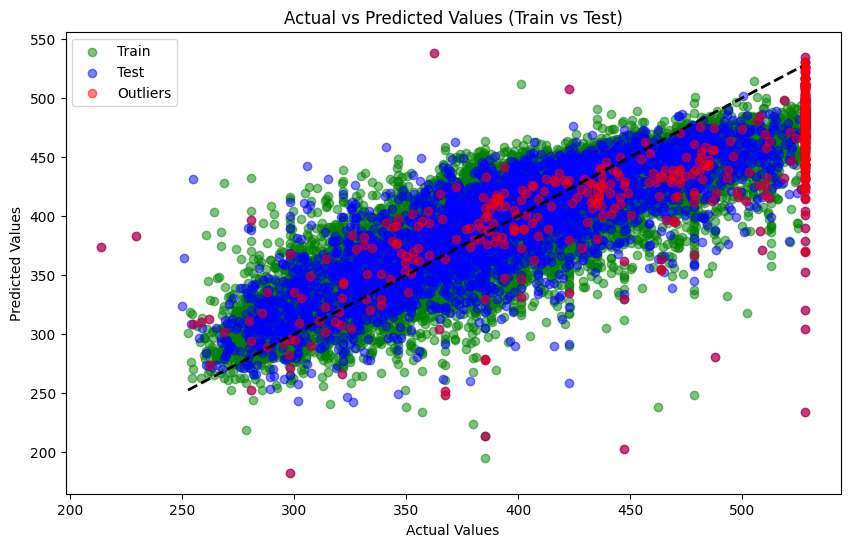

In [68]:

y_train_pred = best_model.predict(x_train_c)
y_test_pred = best_model.predict(x_test)
y_outliers_pred = best_model.predict(x_test_outliers)

plt.figure(figsize=(10,6))

plt.scatter(y_train_c, y_train_pred, label='Train', alpha=0.5, c='g')
plt.scatter(y_test, y_test_pred, label='Test', alpha=0.5, c='b')
plt.scatter(y_test_outliers, y_outliers_pred, label='Outliers', alpha=0.5, c='r')


plt.plot([y_train_c.min(), y_train_c.max()],
         [y_train_c.min(), y_train_c.max()],
         'k--', linewidth=2)

plt.title("Actual vs Predicted Values (Train vs Test)")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.show()


**Interpretation**

The scatter plot compares the model’s predictions against the true target values for both the training and test sets. The diagonal dashed line represents ideal performance (prediction = actual).

1. Main Trend

Both the train (green) and test (blue) points align reasonably well with the diagonal line, indicating that the model captures the general relationship between features and the target.

2. Underprediction at High Values

At the high end of the target range, the points fall clearly below the diagonal line.
This means:
* Actual value is high
* Predicted value is significantly lower
* The gap widens as the true value increases

This behavior shows that:
* The model systematically underpredicts expensive houses.
* A linear model struggles to capture the non-linear relationship in this upper region.
* A more expressive model (Polynomial Regression, Random Forest, XGBoost, etc.) could reduce this bias.

3. Outliers (Red Points)

The red points indicate outliers detected in the test set.
There is a vertical red band at the right side of the plot. These correspond to houses whose median_house_value was capped at $500,000 in the original dataset.
Since many values were artificially truncated to the same number, they form a vertical line when plotted.
The test set still contains these capped values, and the model (which never saw them during training) predicts them with a wide range of values, producing that vertical cluster.

4. Conclusion
* The model fits the central range well.
* It has difficulty generalizing to extreme high-value homes.
* Outliers behave differently from normal samples because they lie outside the model’s learned region.
* Underprediction suggests the need for a more flexible model.

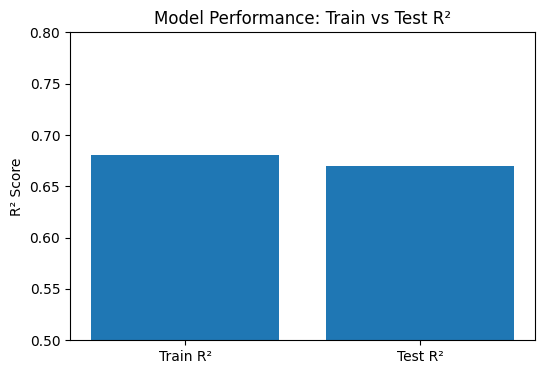

In [69]:
r2_train = best_model.score(x_train_c, y_train_c)
r2_test = best_model.score(x_test, y_test)

plt.figure(figsize=(6,4))
plt.bar(['Train R²', 'Test R²'], [r2_train, r2_test])
plt.title("Model Performance: Train vs Test R²")
plt.ylabel("R² Score")
plt.ylim(0.5,0.8)
plt.show()
